In [60]:
import pandas as pd
#from pandas.tools.plotting import scatter_matrix
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import json
plt.style.use('ggplot')
%matplotlib inline

In [2]:
#read CSV to dataframe and ensure data types
county_df = pd.read_csv('county_aggregates.csv', dtype={'state':'str', 'county':'str'})
county_df['fips'] = county_df.state + county_df.county
county_df['income_multiple'] = (county_df.loan_average_app / 0.80) / county_df.income_average_app
county_df.fips = county_df.fips.map(lambda x: str(x).zfill(5))
county_df.drop('Unnamed: 0', inplace=True, axis = 1)


#FIXME group all XXNA to the state level and drop them from county level -- mark FIPS as NA
county_df.head()


,year,state,county,loan_average_app,income_average_app,count_app,value_app,fips,income_multiple
0,2000,13,005,42.91,33.63,334,14332,13005,1.594930
1,2000,25,025,172.26,92.79,23620,4068697,25025,2.320563
2,2000,55,065,61.86,45.41,422,26106,55065,1.702819
3,2000,38,023,28.00,43.50,6,168,38023,0.804598
4,2000,51,037,59.77,40.45,314,18767,51037,1.847033


In [105]:
#FIXME import tract to CBSA file to get MSAs
cbsa_df = pd.read_csv('tract_to_CBSA_2010.csv', sep='|')
cbsa_df.county = cbsa_df.county.map(lambda x: str(x).zfill(5))
fips_list = set(cbsa_df.county.ravel())


In [78]:
#create county files and put them in directory tree
bad_counties = [] #keep a list of counties that were not valid FIPS
good_counties = []
for county in set(county_df.fips.ravel()):
    
    if str(county) in fips_list: #verify that the FIPS county code is valid
        path = "data/"+str(county)[:2] + "/" + str(county) #set CSV path
        
        if not os.path.exists(path):
            os.makedirs(path)
        
        out_df = county_df[county_df.fips == county].copy()
        
        #create deltas for pattern building
        out_df['loan_avg_app_delta'] = out_df.loan_average_app.pct_change()*100
        out_df['income_average_app_delta'] = out_df.income_average_app.pct_change() *100
        out_df['count_app_delta'] = out_df.count_app.pct_change() *100
        out_df['value_app_delta'] = out_df.value_app.pct_change()
        out_df['income_mult_delta'] = out_df.income_multiple.pct_change()*100
        
        #write CSV
        out_df.to_csv(path + '/data.csv', index=None)
        good_counties.append(str(county))
    else:
        #print "bad county: ", county, len(county)
        bad_counties.append(county)


In [110]:
#for each county, make a list of years in which it has data
county_years = {}
for county in set(county_df.fips.ravel()):
    single_county = county_df[county_df.fips == county].copy()
    county_years[county] = list(single_county.year.ravel())
    

In [111]:
#make a list of counties that have all 15 years of data to build patterns
county_all_years = [] #list of counties with data for all 15 years
for county in county_years.iterkeys():
#    print county, type(county)
    if len(county_years[county]) == 15:
        if str(county) in good_counties: #ensure the county is valid
            county_all_years.append(county)

In [112]:
#create JSON objects with binary patterns for each county
#set columns for pattern building
col_list = ['loan_avg_app_delta', 'income_average_app_delta', 'count_app_delta', 'value_app_delta', 'income_mult_delta']

for county in county_all_years:
    patterns = {} #establish dictionary to hold patterns
    patterns['binaries'] = {} #set pattern sub category

    path = "data/" + county[:2] + "/" + county #set path based on fips codes
    patterns['fips'] = path[len(path)-5:] #set fips header
    load_df = pd.read_csv(path + '/data.csv')

    for col in col_list:
        patterns['binaries'][col] = []
        for item in load_df[col].ravel():
            if item >= 0:
                patterns['binaries'][col].append(1)
            else:
                patterns['binaries'][col].append(0)

    with open(os.path.join(path, 'pattern.json'), 'w') as outfile:
        json.dump(patterns, outfile, indent=4, ensure_ascii = False)


In [28]:
#create 'vulnerable area patterns' for testing
path = "data/26/26163/"
detroit_df = pd.read_csv(path + "data.csv")
path = "data/06/06077/"
stockton_df = pd.read_csv(path + "data.csv")
stockton_df

,year,state,county,loan_average_app,income_average_app,count_app,value_app,fips,income_multiple,loan_avg_app_delta,income_average_app_delta,count_app_delta,value_app_delta,income_mult_delta
0,2000,6,77,122.94,74.85,30334,3729384,6077,2.053106,NaN,NaN,NaN,NaN,NaN
1,2001,6,77,154.89,80.01,60126,9312760,6077,2.419854,25.988287,6.893788,98.213226,1.497131,17.863058
2,2002,6,77,166.96,84.15,71663,11964989,6077,2.480095,7.792627,5.174353,19.188038,0.284795,2.489460
3,2003,6,77,182.89,84.88,105793,19348582,6077,2.693361,9.541207,0.867499,47.625692,0.617100,8.599112
4,2004,6,77,219.60,89.55,105497,23167540,6077,3.065327,20.072175,5.501885,-0.279792,0.197377,13.810454
5,2005,6,77,268.32,102.33,119885,32167672,6077,3.277631,22.185792,14.271357,13.638303,0.388480,6.926001
6,2006,6,77,284.29,119.02,96789,27516163,6077,2.985738,5.951849,16.309978,-19.265129,-0.144602,-8.905624
7,2007,6,77,289.98,121.24,61769,17912039,6077,2.989731,2.001477,1.865233,-36.181798,-0.349036,0.133750
8,2008,6,77,229.98,108.53,100804,23182808,6077,2.648807,-20.691082,-10.483339,63.195130,0.294258,-11.403177
9,2009,6,77,192.57,100.24,17620,3393022,6077,2.401362,-16.266632,-7.638441,-82.520535,-0.853641,-9.341755


(0, 130.0)

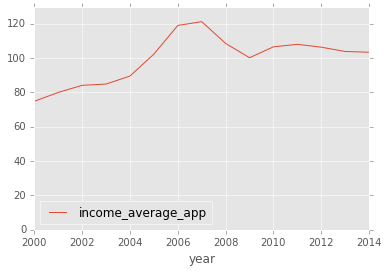

In [31]:
ax = stockton_df.plot.line(x='year', y='income_average_app')
ax.set_ylim(0)

In [37]:
patterns = {}
patterns['binaries'] = {}
patterns['binaries']['detroit'] = []
patterns['binaries']['stockton'] = []
for item in detroit_df.loan_avg_app_delta.ravel():
    if item >= 0:
        patterns['binaries']['detroit'].append(1)
    else:
        patterns['binaries']['detroit'].append(0)

for item in stockton_df.loan_avg_app_delta.ravel():
    if item >= 0:
        patterns['binaries']['stockton'].append(1)
    else:
        patterns['binaries']['stockton'].append(0)



In [39]:
print patterns['binaries']['stockton']
print patterns['binaries']['detroit']

[0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1]
[0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1]


In [84]:
#create boom bust recovery pattern
#2000 - 2007 is boom: threshold is gain of 40% or more
#2007 - 2009 is crash: threshold is loss of 30% or more 
#2009 - 2014 is recovery: threshold is increase of less than 20%

detroit_df

,year,state,county,loan_average_app,income_average_app,count_app,value_app,fips,income_multiple,loan_avg_app_delta,income_average_app_delta,count_app_delta,value_app_delta,income_mult_delta
0,2000,26,163,80.76,55.81,124779,10077585,26163,1.808816,NaN,NaN,NaN,NaN,NaN
1,2001,26,163,99.76,64.68,185070,18463392,26163,1.927953,23.526498,15.893209,48.318227,0.832125,6.586485
2,2002,26,163,111.82,67.83,202261,22617368,26163,2.060666,12.089014,4.870130,9.288918,0.224984,6.883641
3,2003,26,163,118.47,71.40,252137,29870220,26163,2.074055,5.947058,5.263158,24.659227,0.320676,0.649705
4,2004,26,163,112.80,66.18,209296,23607811,26163,2.130553,-4.786022,-7.310924,-16.991160,-0.209654,2.724056
5,2005,26,163,109.77,67.54,229915,25236739,26163,2.031574,-2.686170,2.055002,9.851598,0.069000,-4.645702
6,2006,26,163,104.89,70.09,203418,21336168,26163,1.870631,-4.445659,3.775540,-11.524694,-0.154559,-7.922098
7,2007,26,163,115.06,75.00,125089,14393182,26163,1.917667,9.695872,7.005279,-38.506425,-0.325409,2.514449
8,2008,26,163,125.17,80.57,172940,21646068,26163,1.941945,8.786720,7.426667,38.253563,0.503911,1.266030
9,2009,26,163,141.80,92.81,29405,4169740,26163,1.909816,13.285931,15.191759,-82.996993,-0.807367,-1.654483


In [120]:
#create 'vulnerable area patterns' for testing
path_detroit = "data/26/26163/"
#detroit_df = pd.read_csv(path + "data.csv")
path_stockton = "data/06/06077/"
#stockton_df = pd.read_csv(path + "data.csv")
df_list = [path_detroit, path_stockton] #list of counties to process

#FIXME to .iloc


for path in df_list:

    df_pattern = {}
    df_pattern['county'] = str(path[len(path)-6:])[:-1]
    df_pattern['bbr']= []
    df = pd.read_csv(path + "data.csv")
    boom_start = df.loc[0, 'loan_average_app']
    boom_end = df.loc[7, 'loan_average_app']
    delta = (boom_end - boom_start)/boom_start
    df_pattern['bbr'].append(delta)
    #write pattern to JSON
    print delta
print df_pattern

0.424715205547
1.35871156662
{'county': '06077', 'bbr': [1.3587115666178626]}


In [183]:
bbr_calc_dict = {}
bbr_calc_dict['boom_years'] = {2000: "", 2007: ""} #set dict for index locations of boom years in dataframes
bbr_calc_dict['bust_years'] = {2007: "", 2009: ""}
bbr_calc_dict['recovery_years'] = {2009: "", 2014: ""}

#
#df.index.get_loc(label)
#print type(bbr_calc_dict['boom_years'][2000])

category_list = [cat for cat in bbr_calc_dict.iterkeys()]
for cat in category_list:
    for  year in bbr_calc_dict[cat].iterkeys():
        bbr_calc_dict[cat][year]= detroit_df.year[detroit_df.year == year].index[0]

bbr_calc_dict['columns_to_calc'] = {}      
bbr_calc_dict

{'boom_years': {2000: 0, 2007: 7},
 'bust_years': {2007: 7, 2009: 9},
 'columns_to_calc': {},
 'recovery_years': {2009: 9, 2014: 14}}

In [203]:
patterns['bbr'] = {}
#print stockton_df.columns.ravel()

col_list + ['loan_average_app', 'income_average_app', 'count_app', 'value_app', 'income_multiple']
for col in col_list:
    bbr_calc_dict['columns_to_calc'][col] = stockton_df.columns.get_loc(col)
print bbr_calc_dict
#for col in col_list:
 #   print stockton_df[(stockton_df.year==2001)][col].index[0]

 {'recovery_years': {2009: 9, 2014: 14}, 'boom_years': {2000: 0, 2007: 7}, 'columns_to_calc': {'loan_avg_app_delta': 9, 'income_multiple': 8, 'count_app': 5, 'count_app_delta': 11, 'income_average_app_delta': 10, 'value_app_delta': 12, 'income_mult_delta': 13, 'loan_average_app': 3, 'value_app': 6, 'income_average_app': 4}, 'bust_years': {2009: 9, 2007: 7}}


In [236]:
#calculate rate of change in a county for boom, bust, recovery
#calculate for multiple columns and store patterns
#recovery_years is row index, columns_to_calc is column index
#print bbr_calc_dict['recovery_years'][2009], bbr_calc_dict['columns_to_calc']['loan_average_app']
#calculate recovery deltas
for column in bbr_calc_dict['columns_to_calc'].iterkeys():
    patterns['bbr'][column] = {}
    patterns['bbr'][column]['recovery'] = []
    start = True

    start_row = bbr_calc_dict['recovery_years'][2009] #returns integer index of year
    end_row = bbr_calc_dict['recovery_years'][2014]
    col = bbr_calc_dict['columns_to_calc'][column] #returns integer index of column label

    start_val = stockton_df.iloc[start_row, col]
    end_val = stockton_df.iloc[end_row, col]
    delta = abs(((end_val - start_val) / start_val) *100) #check the validity of absolute value usage.
    patterns['bbr'][column]['recovery'].append(delta)
    #print "rows:",start_row,end_row, "col:",col, column
    #print end_val, start_val, end_val - start_val, delta

rows: 9 14 col: 9 loan_avg_app_delta
12.7671178541 -16.266631881 29.0337497351 178.486548091
rows: 9 14 col: 8 income_multiple
2.74871894035 2.40136173184 0.34735720851 14.4650097444
rows: 9 14 col: 5 count_app
16787.0 17620.0 -833.0 4.72758229285
rows: 9 14 col: 11 count_app_delta
-30.1850696611 -82.5205348994 52.3354652383 63.4211415402
rows: 9 14 col: 10 income_average_app_delta
-0.404429465575 -7.63844098406 7.23401151848 94.7053401811
rows: 9 14 col: 12 value_app_delta
-0.21271162937 -0.853640594358 0.640928964988 75.081828257
rows: 9 14 col: 13 income_mult_delta
13.225033251 -9.3417553676 22.5667886186 241.569038479
rows: 9 14 col: 3 loan_average_app
227.44 192.57 34.87 18.1077010957
rows: 9 14 col: 6 value_app
3818014.0 3393022.0 424992.0 12.5254713939
rows: 9 14 col: 4 income_average_app
103.43 100.24 3.19 3.18236233041


In [234]:
patterns

#stockton_df

{'bbr': {'count_app': {'boom': [4.7275822928490348]},
  'count_app_delta': {'boom': [63.421141540225911]},
  'income_average_app': {'boom': [3.1823623304070354]},
  'income_average_app_delta': {'boom': [94.705340181079251]},
  'income_mult_delta': {'boom': [241.56903847930303]},
  'income_multiple': {'boom': [14.465009744443785]},
  'loan_average_app': {'boom': [18.107701095705462]},
  'loan_avg_app_delta': {'boom': [178.48654809120285]},
  'value_app': {'boom': [12.525471393937321]},
  'value_app_delta': {'boom': [75.081828257010827]}},
 'binaries': {'count_app_delta': [0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0],
  'income_average_app_delta': [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0],
  'income_mult_delta': [0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0],
  'loan_avg_app_delta': [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0],
  'value_app_delta': [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0]},
 'fips': '40031'}

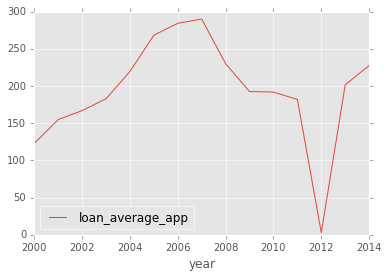

In [225]:
stockton_df.plot.line(x='year', y='loan_average_app')